In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import minimize as som

from matplotlib import colors as mcolors
from matplotlib import tri
from matplotlib.patches import Rectangle

from mpl_toolkits.axes_grid1 import host_subplot

from cpymad.madx import Madx

%matplotlib inline

import seaborn as sns

sns.set('talk', font_scale=1.2, rc={'figure.figsize':(8.3,5.2), 'lines.linewidth': 3})

sns.set_style('ticks',
               {'grid.linestyle': 'none', 'axes.edgecolor': '0',
                'axes.linewidth': 1.2, 'legend.frameon': True,
                'xtick.direction': 'out', 'ytick.direction': 'out',
                'xtick.top': True, 'ytick.right': True,
               })


In [3]:
# globals 
Qx, Qy = 18.75, 18.8
dk = 1e-3

## synchrotron lattice setup

In [4]:
match = '''match,sequence=sis100ring;
VARY,NAME=kqd,STEP=1e-8;
VARY,NAME=kqf,STEP=1e-8;
GLOBAL,sequence=sis100ring,Q1={},Q2={};LMDIF,CALLS=2000,TOLERANCE=1.0E-8;
endmatch;

twiss; '''

# input for cold lattice
cold_str = '''CALL, FILE = "Optics-YEH-Jan19-from-Elegant.str";
CALL, FILE = "sis100cold.seq";

beam, particle = ion, mass= 221.6955947052, charge=28, sequence=SIS100RING, energy = 269.29559470519996; !beta = 0.5676897813711054;
use, sequence=SIS100RING;

kqd : = -2.158585731120552e-01*LQD;
kqf : = 2.165932886180960e-01*LQD;

K1NL_S00QD1D:=kqd;
K1NL_S00QD1F:=kqf;
K1NL_S00QD2F:=kqf;'''

In [5]:
madx = Madx(stdout=False)
madx.input(cold_str + match.format(Qx, Qy))
twiss = madx.table.twiss.dframe()

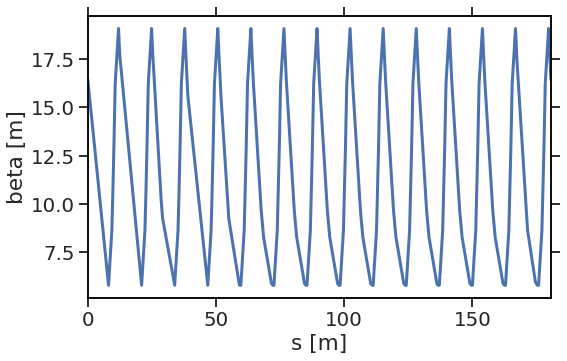

In [6]:
plt.plot(twiss['s'], twiss['betx'])
#plt.plot(twiss['s'], twiss['bety'])

plt.xlim(0, 1083.6 / 6)

plt.xlabel("s [m]")
plt.ylabel("beta [m]")

plt.show();

## select quadrupoles

In [7]:
names = [name.strip()[:-2] for name in twiss[twiss["keyword"].str.contains("quadrupole")]["name"].tolist()]

In [8]:
errors = np.random.normal(0, dk, len(names))

add_errors = ""
for name, error_val in zip(names, errors):
    add_errors += "SELECT, FLAG=error, clear;eoption, add=false;"
    add_errors += f'''SELECT, FLAG=error, PATTERN="{name}*";''' 
    add_errors += '''EFCOMP, ORDER=1, RADIUS=0.01,
    DKNR={0,''' + str(error_val) + "},DKSR={0, 0};\n"

#add_errors += "SELECT, FLAG = ERROR, FULL;ESAVE,FILE ='test';"

In [9]:
madx.input(add_errors+"twiss;")
twiss_err = madx.table.twiss.dframe()

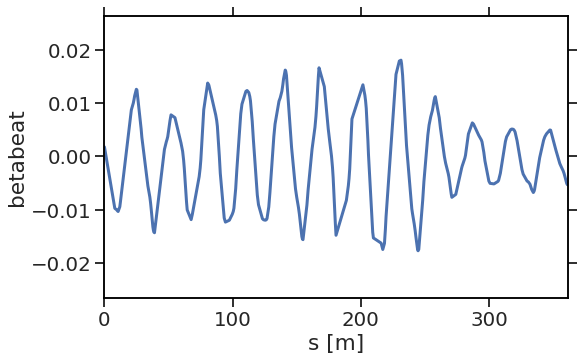

In [10]:
plt.plot(twiss['s'], twiss_err['bety'] / twiss['bety'] - 1)

plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

In [11]:
def set_quads(dk):
    add_correctors = '''
    K1NL_S00QD1D:=kqd+{};
    K1NL_S00QD1F:=kqf+{};
    K1NL_S00QD2F:=kqf+{};
    K1NL_S19QS1J:={};
    K1NL_S1DQS1J:={};
    K1NL_S29QS1J:={};
    K1NL_S2DQS1J:={};
    K1NL_S39QS1J:={};
    K1NL_S3DQS1J:={};
    K1NL_S49QS1J:={};
    K1NL_S4DQS1J:={};
    K1NL_S59QS1J:={};
    K1NL_S5DQS1J:={};
    K1NL_S69QS1J:={};
    K1NL_S6DQS1J:={};'''.format(*dk)
    madx.input(add_correctors + "twiss;")
    
    return madx.table.summ.q1[0], madx.table.summ.q2[0]


In [12]:
def find_betabeat(twiss_ref, twiss_curr):
    
    beat_x = np.std(twiss_curr["betx"] / twiss_ref["betx"] - 1.)
    beat_y = np.std(twiss_curr["bety"] / twiss_ref["bety"] - 1.)
    
    return np.sqrt(beat_x**2 + beat_y**2)


In [13]:
def objective(theta, twiss_ref):
    
    dk = normalize(theta)
    qx, qy = set_quads(dk)
    twiss_curr = madx.table.twiss.dframe()
    
    return find_betabeat(twiss_ref, twiss_curr)


def hyper_surface(theta, qx0, qy0):

    #print("hyper-surface computation")
    
    dk = normalize(theta)
    qx, qy = set_quads(dk)
    
    out = np.sqrt((qx - qx0)**2 + (qy - qy0)**2)
    #print("the distance from set tunes hor:{} ver:{}".format(qx - qx0,qy - qy0))
    #print("out is {}\n".format(out))

    return -out

def normalize(theta):

    #print("theta is {}".format(theta))

    alpha = 2 * 18.5**2 * (2 * np.pi / 1083.6)**2
    
    n_quads = np.ones(len(theta))
    n_quads[0] = 84.
    n_quads[1] = 36.
    n_quads[2] = 48.
    
    dk = alpha * theta / n_quads
       
    #print("dk is {}".format(dk))
    
    return dk

In [14]:
method = 'COBYLA'
epsilon, ftol, catol = 0.5, 1e-6, 1e-6

cons = [{"type": "ineq", "fun":hyper_surface, "args":(Qx,Qy)}]
optionsDict = {'rhobeg':epsilon, 'catol':catol, "tol":ftol,'disp': True}
arg = (twiss,)

theta = np.zeros(15)

In [15]:
find_betabeat(twiss, twiss_err)

0.013942207444427304

In [16]:
vec = som(objective, theta, method=method, constraints=cons, options=optionsDict, args=arg)

In [17]:
dk = normalize(vec.x)
set_quads(dk)
twiss_curr = madx.table.twiss.dframe()

In [18]:
vec

     fun: 0.025156842191321912
   maxcv: 0.005637018868943616
 message: 'Did not converge to a solution satisfying the constraints. See `maxcv` for magnitude of violation.'
    nfev: 1000
  status: 4
 success: False
       x: array([-0.12035301,  0.45905092,  0.2955835 , -0.04576617, -0.10487618,
        0.00650961,  0.02583999, -0.00699706, -0.01136526, -0.01316177,
        0.00976179, -0.03406166, -0.09996216,  0.02351302,  0.10730027])

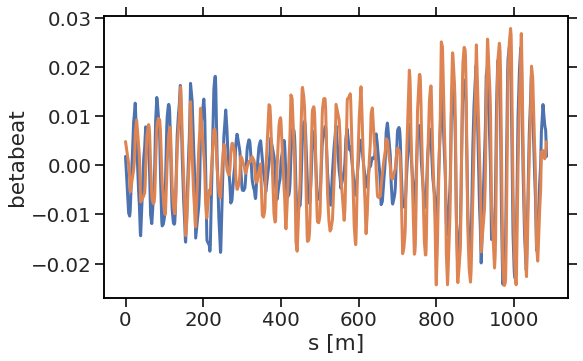

In [19]:
plt.plot(twiss_err['s'], twiss_err['bety'] / twiss['bety'] - 1)
plt.plot(twiss_curr['s'], twiss_curr['bety'] / twiss['bety'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

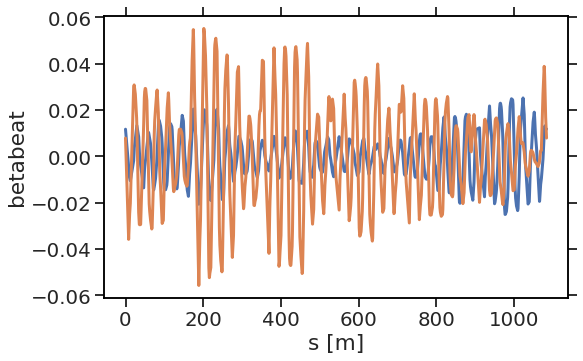

In [20]:
plt.plot(twiss_err['s'], twiss_err['betx'] / twiss['betx'] - 1)
plt.plot(twiss_curr['s'], twiss_curr['betx'] / twiss['betx'] - 1)

#plt.xlim(0, 1083.6 / 3)

plt.xlabel("s [m]")
plt.ylabel("betabeat")

plt.show();

In [37]:
find_betabeat(twiss, twiss_err)

0.00917106660149616

In [38]:
find_betabeat(twiss, twiss_curr)

0.009175573397472075